# Una breve introduccion a lo que queremos del curso

Este notebook introduce un ejemplo de lo que queremos que sepan hacer hacia el final del curso. Conceptualmente, el procedimiento es:

*   Explorar los datos
*   Plantear el problema a resolver
*   Preprocesar los datos a un formato adecuado
*   Elegir algoritmos
*   Fittear y validar
*   Decidir el algoritmo final, y testear




Antes que nada, importamos algunos paquetes:

In [1]:
import numpy as np 
import os 
import sys 
import tarfile #read and write tar archives
import sklearn
import matplotlib.pyplot as plt

%matplotlib inline
# to make this notebook's output stable across runs
np.random.seed(42)

import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Los datos

Vamos a utilizar el dataset de California. Una buena practica es, si los datos lo permiten, separar un conjunto de test que voy a utilizar solamente al final de todo, para evaluar todo lo que hice.

## Traemos los datos

Como estoy trabajando en local modifico el HOUSING_PATH para que referencia a la carpeta donde se encuetra el csv

In [2]:
HOUSING_PATH = r"C:\Users\User\Repositorios\Aprendizaje-Automatico-UNSAM-1C-2021\Clase N°2 - 11-03-2021 - Ejemplo de los pasos a seguir para un proyecto"

#Esta funcion toma el path donde se encuentra el csv, realiza la lectura y carga en un DataFrame de Pandas

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
#Lectura de datos si estoy trabajando en Google Colab

if 'google.colab' in sys.modules:
        
    import tarfile

    DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/"
    HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

    !mkdir -p ./datasets/housing

    def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
        os.makedirs(housing_path, exist_ok=True)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        #urllib.request.urlretrieve(housing_url, tgz_path)
        !wget {HOUSING_URL} -P {housing_path}
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()

    # Corramos la función
    fetch_housing_data()

else: 
    print("Not running on Google Colab. This cell is did not do anything.")

Not running on Google Colab. This cell is did not do anything.


## Preprocesamos un poco

In [4]:
#Realizamos la lectura del csv

housing_pre = load_housing_data()

In [5]:
#5 primeras filas del dataset

housing_pre.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Train/test splitting

Como bien discutimos, es menester separar los datos en dos conjuntos: el de entrenamiento y el de testeo. Este ultimo debe utilizarse al FINAL del proyecto para garantizar una prediccion no sesgada de la performance del modelo final.

La opcion mas sencilla es utilizar `train_test_split`, donde especificamos el porcentaje de datos que separamos para testear.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [6]:
train_df, test_df = train_test_split(housing_pre, test_size=0.2, random_state=42)

In [7]:
#Observamos el tamaño de los dataframes obtenidos y el cumplimiento del % de split especificado

print('Housing: ' + str(len(housing_pre)))
print('Train: ' + str(len(train_df)))
print('Test: ' + str(len(test_df)))

print('')

print('% Train: ' + str((len(train_df)/len(housing_pre))*100))
print('% Test: ' + str((len(test_df)/len(housing_pre))*100))

Housing: 20640
Train: 16512
Test: 4128

% Train: 80.0
% Test: 20.0


Fijando el valor de random_state (semilla) permite ontener reproducibilidad en el split. Esto permite fijar y utilizar siempre la misma generacion de aleatoriedad en el proceso random del split

Del glosario de sklearn:

    random_state: Whenever randomization is part of a Scikit-learn algorithm, a random_state parameter may be provided to control the random number generator used. Note that the mere presence of random_state doesn’t mean that randomization is always used, as it may be dependent on another parameter, e.g. shuffle, being set.

Ejecutando reiteradamente train_test_split con el mismo valor de random_state y observando una fila en particular se puede ver que siempre se selecciona la misma. A continuacion se muestra un ejemplo.

In [8]:
#Observando la 1° fila del dataset de entrenamiento luego de train_test_split

train_df.iloc[0]

longitude                -117.03
latitude                   32.71
housing_median_age            33
total_rooms                 3126
total_bedrooms               627
population                  2300
households                   623
median_income             3.2596
median_house_value        103000
ocean_proximity       NEAR OCEAN
Name: 14196, dtype: object

Un problema que puede aparecer es que este splitting no sea representativo en algunos features. Por ejemplo, `median_income`. Definiendo una variable auxiliar `income_cat` con los valores binneados de `median_income` podemos estudiar esto

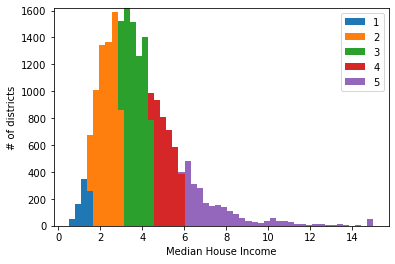

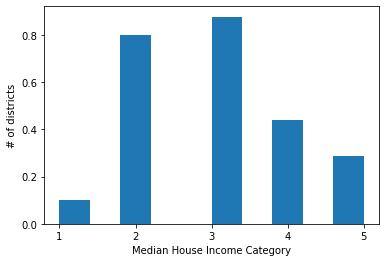

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [9]:
# Creo una nueva columna 'income_cat' donde almeceno en forma categorica (en bins) los valores de 'median_income'
housing_pre["income_cat"] = pd.cut(housing_pre["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

#Realizo el grafico de la cantidad de distritos que se encuentran en cada categoria. Cada categoria se discretiza en bins
plt.hist([housing_pre[housing_pre["income_cat"] == cat].median_income for cat in range(1,6)], 
         label =  list(range(1,6)), 
         bins=50,
         stacked=True)
plt.legend()
plt.ylabel('# of districts')
plt.xlabel('Median House Income')
plt.show()

#Grafico la densidad de cada bin
plt.hist(housing_pre['income_cat'], density=True)
plt.xticks([1,2,3,4,5])
plt.ylabel('# of districts')
plt.xlabel('Median House Income Category')
plt.show()

housing_pre['income_cat'].value_counts() / len(housing_pre)

Veamos que pasa con `income_cat` con el `train_test_split` por defecto

3    0.348595
2    0.317466
4    0.178537
5    0.115673
1    0.039729
Name: income_cat, dtype: float64

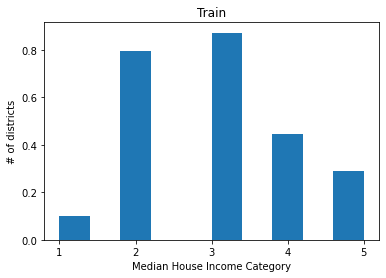

In [10]:
#Comportamiento para train

train_df, test_df = train_test_split(housing_pre, test_size=0.2, random_state=42)

plt.hist(train_df['income_cat'], density=True)
plt.xticks([1,2,3,4,5])
plt.ylabel('# of districts')
plt.xlabel('Median House Income Category')
plt.title('Train')
train_df['income_cat'].value_counts() / len(train_df)

3    0.358527
2    0.324370
4    0.167393
5    0.109496
1    0.040213
Name: income_cat, dtype: float64

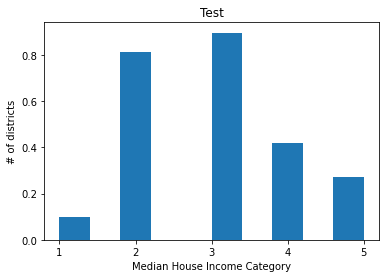

In [11]:
#Comportamiento para test

train_df, test_df = train_test_split(housing_pre, test_size=0.2, random_state=42)

plt.hist(test_df['income_cat'], density=True)
plt.xticks([1,2,3,4,5])
plt.ylabel('# of districts')
plt.xlabel('Median House Income Category')
plt.title('Test')
test_df['income_cat'].value_counts() / len(test_df)

Comparando los % obtenidos para la separacion en bins y por medio de train_test_split la diferencia no es significativa en este caso. Pero cuidado, en otros caso esta diferencia puede ser mayor y podemos subsamplear algunas categorias de interes

A continuacion realiza el mismo analisis pero utilizando los Quartiles

In [12]:
q = housing_pre["median_income"].quantile([.25, .50,.75]) 
q

0.25    2.56340
0.50    3.53480
0.75    4.74325
Name: median_income, dtype: float64

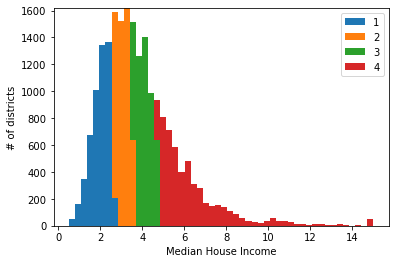

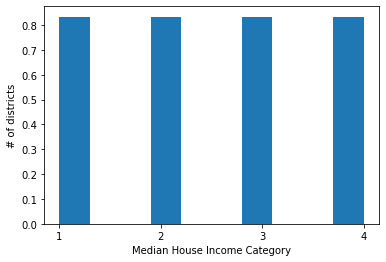

4    0.25
3    0.25
2    0.25
1    0.25
Name: income_cat_q, dtype: float64

In [13]:
housing_pre["income_cat_q"] = pd.cut(housing_pre["median_income"],
                               bins=[0., q.values[0], q.values[1], q.values[2], np.inf],
                               labels=[1, 2, 3, 4])

#Realizo el grafico de la cantidad de distritos que se encuentran en cada categoria. Cada categoria se discretiza en bins
plt.hist([housing_pre[housing_pre["income_cat_q"] == cat].median_income for cat in range(1,5)], 
         label =  list(range(1,5)), 
         bins=50,
         stacked=True)
plt.legend()
plt.ylabel('# of districts')
plt.xlabel('Median House Income')
plt.show()

#Grafico la densidad de cada bin
plt.hist(housing_pre['income_cat_q'], density=True)
plt.xticks([1,2,3,4])
plt.ylabel('# of districts')
plt.xlabel('Median House Income Category')
plt.show()

housing_pre['income_cat_q'].value_counts() / len(housing_pre)

4    0.253694
1    0.248910
3    0.248849
2    0.248547
Name: income_cat_q, dtype: float64

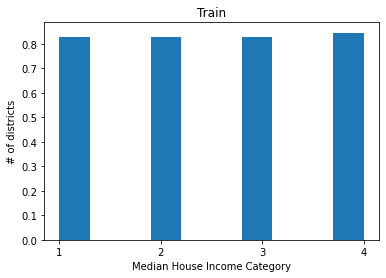

In [14]:
#Comportamiento para train

train_df, test_df = train_test_split(housing_pre, test_size=0.2, random_state=42)

plt.hist(train_df['income_cat_q'], density=True)
plt.xticks([1,2,3,4])
plt.ylabel('# of districts')
plt.xlabel('Median House Income Category')
plt.title('Train')
train_df['income_cat_q'].value_counts() / len(train_df)

2    0.255814
3    0.254603
1    0.254360
4    0.235223
Name: income_cat_q, dtype: float64

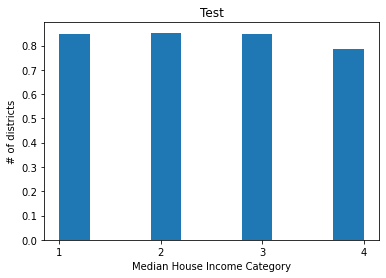

In [15]:
#Comportamiento para test

plt.hist(test_df['income_cat_q'], density=True)
plt.xticks([1,2,3,4])
plt.ylabel('# of districts')
plt.xlabel('Median House Income Category')
plt.title('Test')
test_df['income_cat_q'].value_counts() / len(test_df)

Nuevamente los resultados son muy similares, aun asi debemos tener cuidado al momento de realizar train_test_split para evitar problemas

Otra opcion es obligar a respetar proporciones utilizando `StratifiedShuffleSplit`

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

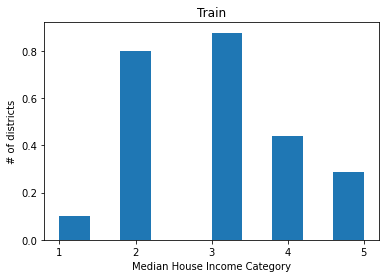

In [16]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543) #Instancio la clase

#Obtengo los indices del split y armo los datasets de train y test con ellos
for train_index, test_index in sss.split(housing_pre, housing_pre["income_cat"]):
    california_housing_train = housing_pre.loc[train_index]
    california_housing_test = housing_pre.loc[test_index]

plt.hist(california_housing_train['income_cat'], density=True)
plt.xticks([1,2,3,4,5])
plt.ylabel('# of districts')
plt.xlabel('Median House Income Category')
plt.title('Train')
california_housing_test['income_cat'].value_counts() / len(california_housing_test)    

In [17]:
#Cantidad de registros train

len(california_housing_train)

16512

In [18]:
#Cantidad de registros de test

len(california_housing_test)

4128

2    0.251211
1    0.249758
3    0.249637
4    0.249394
Name: income_cat_q, dtype: float64

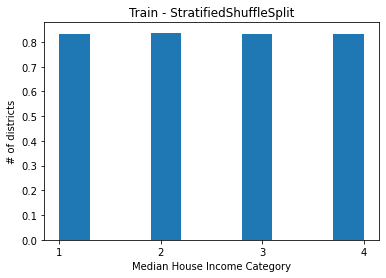

In [19]:
#Comportamiento para train

plt.hist(california_housing_train['income_cat_q'], density=True)
plt.xticks([1,2,3,4])
plt.ylabel('# of districts')
plt.xlabel('Median House Income Category')
plt.title('Train - StratifiedShuffleSplit')
california_housing_train['income_cat_q'].value_counts() / len(california_housing_train)

4    0.252422
3    0.251453
1    0.250969
2    0.245155
Name: income_cat_q, dtype: float64

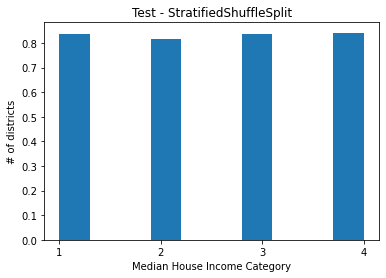

In [20]:
#Comportamiento para test

plt.hist(california_housing_test['income_cat_q'], density=True)
plt.xticks([1,2,3,4])
plt.ylabel('# of districts')
plt.xlabel('Median House Income Category')
plt.title('Test - StratifiedShuffleSplit')
california_housing_test['income_cat_q'].value_counts() / len(california_housing_test)

Para comparar ambos metodos, podemos hacer

In [21]:
#Comparacion para train

comparison_df_train = pd.concat([housing_pre['income_cat'].value_counts() / len(housing_pre), train_df['income_cat'].value_counts() / len(train_df),california_housing_train['income_cat'].value_counts() / len(california_housing_train)], axis=1)
comparison_df_train.columns = ['Train - original', 'Train - random_split', 'Train - stratified_split']
comparison_df_train

,Train - original,Train - random_split,Train - stratified_split
3,0.350581,0.348595,0.350594
2,0.318847,0.317466,0.318859
4,0.176308,0.178537,0.176296
5,0.114438,0.115673,0.114402
1,0.039826,0.039729,0.039850


In [22]:
#Comparacion para test

comparison_df_test = pd.concat([housing_pre['income_cat'].value_counts() / len(housing_pre), test_df['income_cat'].value_counts() / len(test_df),california_housing_test['income_cat'].value_counts() / len(california_housing_test)], axis=1)
comparison_df_test.columns = ['Test - original', 'Test - random_split', 'Test - stratified_split']
comparison_df_test

,Test - original,Test - random_split,Test - stratified_split
3,0.350581,0.358527,0.350533
2,0.318847,0.324370,0.318798
4,0.176308,0.167393,0.176357
5,0.114438,0.109496,0.114583
1,0.039826,0.040213,0.039729


La diferencia no es _enorme_ pero puede ser importante, especialmente para datasets chicos

Una vez que decidi, puedo sacarme de encima esta categoria auxiliar

In [23]:
for set_ in (california_housing_train, california_housing_test):
    set_.drop("income_cat", axis=1, inplace=True)

In [24]:
for set_ in (california_housing_train, california_housing_test):
    set_.drop("income_cat_q", axis=1, inplace=True)

In [25]:
california_housing_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 9106 to 6335
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16345 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [26]:
california_housing_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 7937 to 20128
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           4128 non-null   float64
 1   latitude            4128 non-null   float64
 2   housing_median_age  4128 non-null   float64
 3   total_rooms         4128 non-null   float64
 4   total_bedrooms      4088 non-null   float64
 5   population          4128 non-null   float64
 6   households          4128 non-null   float64
 7   median_income       4128 non-null   float64
 8   median_house_value  4128 non-null   float64
 9   ocean_proximity     4128 non-null   object 
dtypes: float64(9), object(1)
memory usage: 354.8+ KB


## Exploremos los datos (nuevamente)

In [27]:
#Utilizamos una copia del DataFrame

housing=california_housing_train.copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000214DF053220>,
      dtype=object)

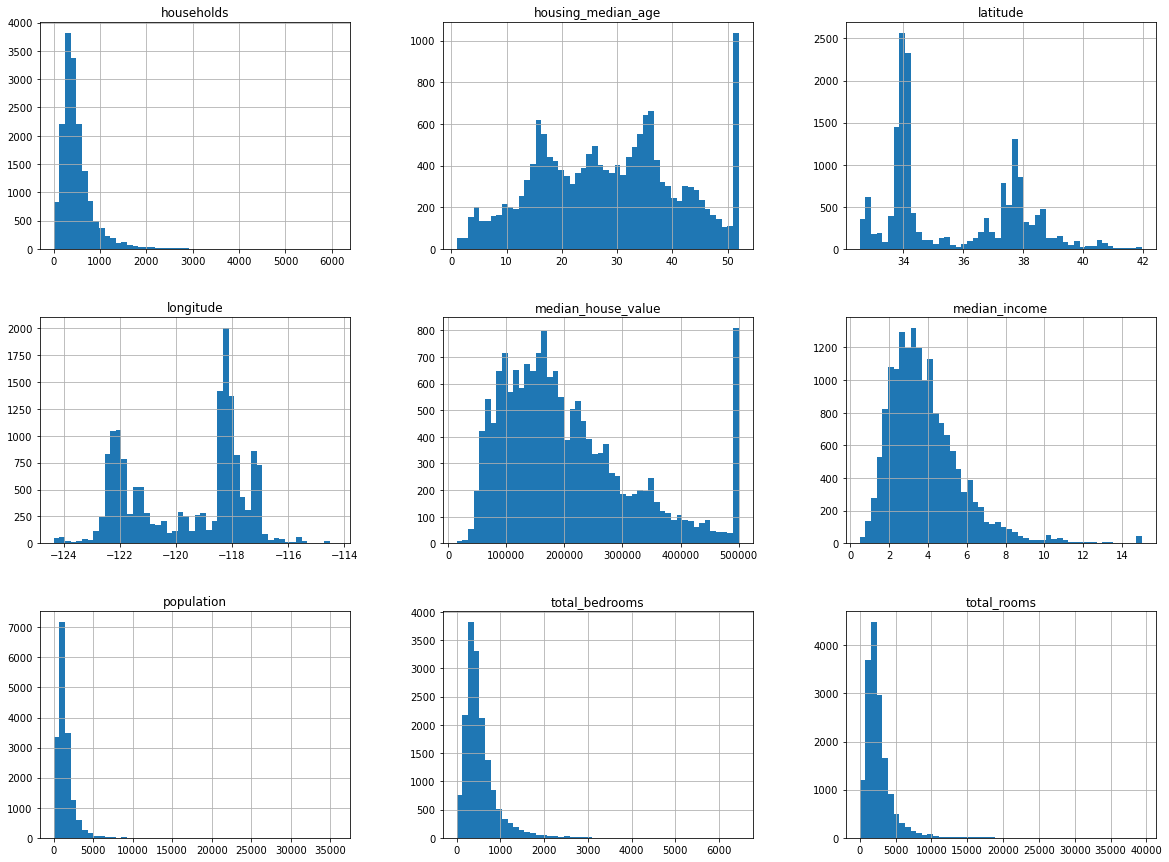

In [28]:
#Grafico un histograma de todas las variables

housing.hist(bins=50, figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000214DEE7F700>,
      dtype=object)

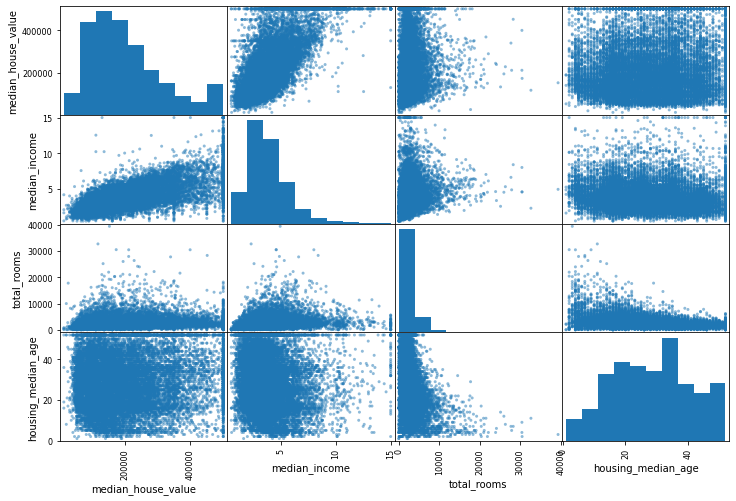

In [29]:
#Realizo un scatterplot de estas 4 variables

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

In [30]:
#Observo los coeficientes de correlacion de las variables con respecto a 'median_house_value'

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.683823
total_rooms           0.138247
housing_median_age    0.105948
households            0.071710
total_bedrooms        0.055660
population           -0.020298
longitude            -0.039310
latitude             -0.151163
Name: median_house_value, dtype: float64

### Valores raros

Como vimos en la clase pasada, hay features con valores raros

C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


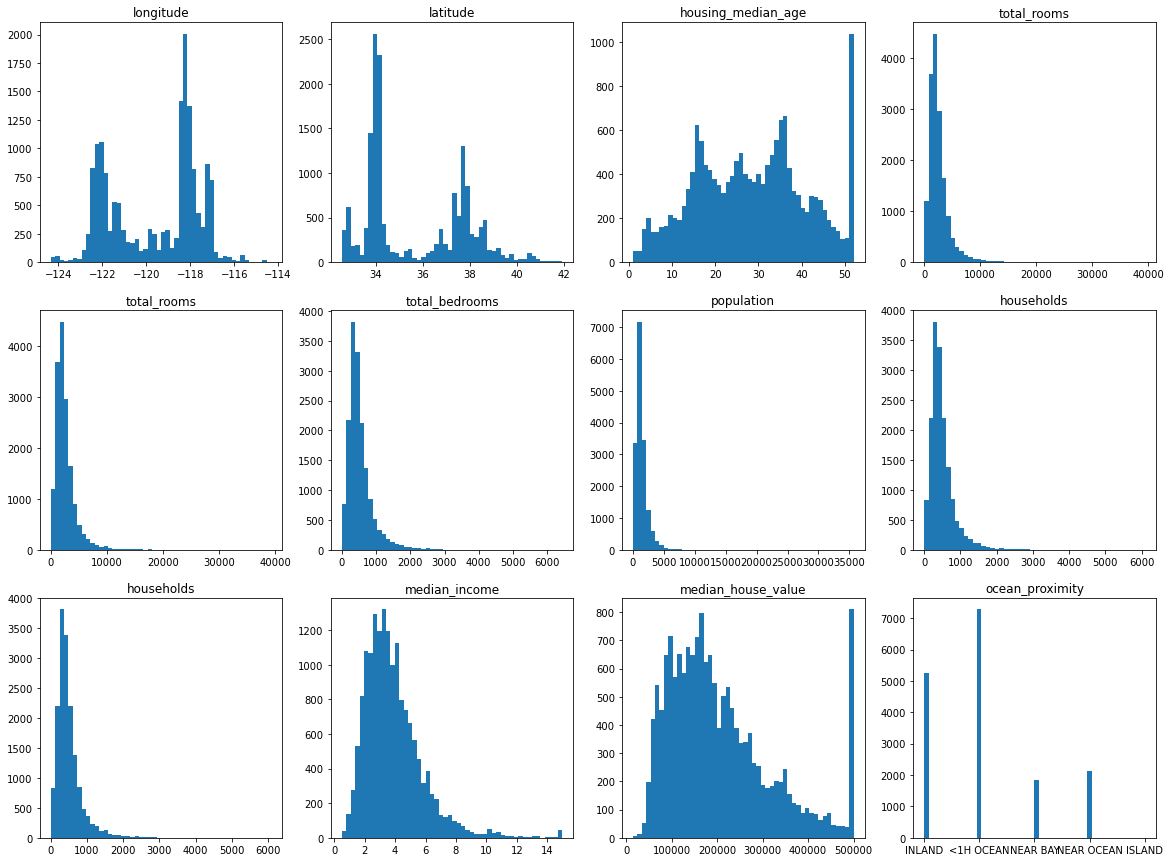

In [31]:
columns = housing.columns.to_list()

N_col = 4
N = len(columns)
N_rows = int(np.ceil(N/N_col))

fig, ax = plt.subplots(N_rows,N_col, figsize=(5*N_col,5*N_rows))

for i in range(N_rows):
    for j in range(N_col):
        ax[i,j].hist(housing[columns[i*N_rows+j]], bins=50)
        ax[i,j].set_title(columns[i*N_rows+j])

Vemos que existe una saturacion en algunos features

In [32]:
problematic_columns = ['median_house_value', 'housing_median_age', 'median_income']
max_values=[]
for col in problematic_columns:
    max_value = housing[col].max()
    print(f"{col}: {sum(housing[col] == max_value)} districts with {col} = {max_value} ({round(sum(housing[col] == max_value)/len(housing)*100,2)}%).")
    max_values.append(max_value)

median_house_value: 762 districts with median_house_value = 500001.0 (4.61%).
housing_median_age: 997 districts with housing_median_age = 52.0 (6.04%).
median_income: 42 districts with median_income = 15.0001 (0.25%).


Cuando pasa esto, tenemos que decir que hacemos. Una opcion es descartarlos y poner una cota a partir de la cual no confiamos en el modelo

In [33]:
housing_clean = housing.copy()
for col, max_value in zip(problematic_columns, max_values):
    housing_clean = housing_clean[housing_clean[col] != max_value]

In [34]:
print(' housing (train) tenia una longitud de ' + str(len(housing)) + ' y ahora tiene una longitud de ' + str(len(housing_clean)))

 housing (train) tenia una longitud de 16512 y ahora tiene una longitud de 14889


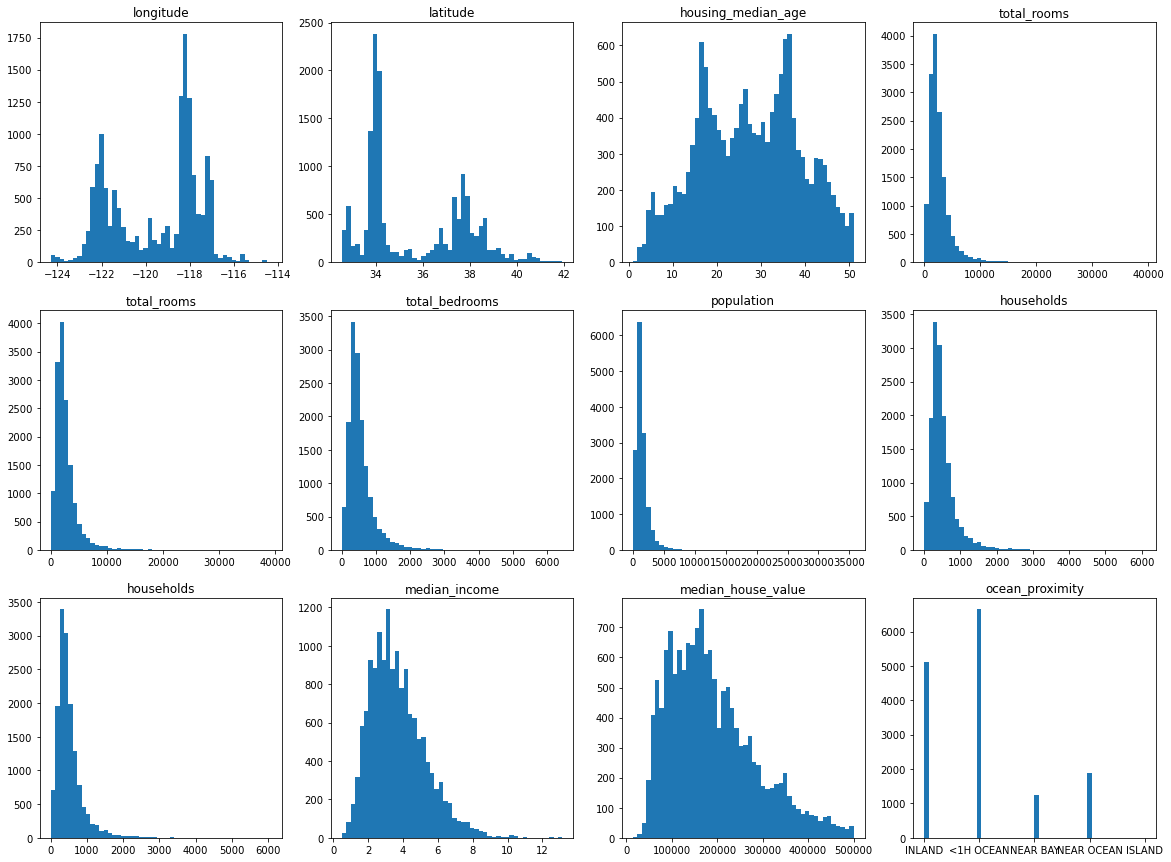

In [35]:
columns = housing_clean.columns.to_list()

N_col = 4
N = len(columns)
N_rows = int(np.ceil(N/N_col))

fig, ax = plt.subplots(N_rows,N_col, figsize=(5*N_col,5*N_rows))

for i in range(N_rows):
    for j in range(N_col):
        ax[i,j].hist(housing_clean[columns[i*N_rows+j]], bins=50)
        ax[i,j].set_title(columns[i*N_rows+j])

Pero ojo! si hacemos esto en entrenamiento tambien tenemos que hacerlo con el conjunto de testeo. Pero ahora utilizamos los max_values ya aprendidos, no volvemos a aprenderlos. Esto lo tenemos que realizar de esta forma para no generar FUGA DE DATOS del dataset de test al dataset de entrenamiento 

In [36]:
housing_test=california_housing_test.copy()
housing_test_clean = housing_test.copy()
for col, max_value in zip(problematic_columns, max_values):
    housing_test_clean = housing_test_clean[housing_test_clean[col] != max_value]

In [37]:
print(' housing (test) tenia una longitud de ' + str(len(housing_test)) + ' y ahora tiene una longitud de ' + str(len(housing_test_clean)))

 housing (test) tenia una longitud de 4128 y ahora tiene una longitud de 3681


### Features faltantes

Si nos fijamos bien en los datos, vemos algo molesto

In [38]:
housing_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14889 entries, 9106 to 6335
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14889 non-null  float64
 1   latitude            14889 non-null  float64
 2   housing_median_age  14889 non-null  float64
 3   total_rooms         14889 non-null  float64
 4   total_bedrooms      14733 non-null  float64
 5   population          14889 non-null  float64
 6   households          14889 non-null  float64
 7   median_income       14889 non-null  float64
 8   median_house_value  14889 non-null  float64
 9   ocean_proximity     14889 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.2+ MB


En efecto, `total_bedrooms` esta incompleto! Cuando pasa esto, tenemos _a grosso modo_ tres opciones

1. Excluir los features incompletos del analisis (esto reduce la cantidad de columnas)
2. Excluir las observaciones o datos donde faltan features del analisis (esto reduce la cantidad de filas).
3. Rellenar los valores faltantes con datos sinteticos utilizando algun criterio.

La eleccion optima depende, como siempre, de los datos y del problema. Nosotros vamos a usar la opcion 3 y llenamos `total_bedrooms` con la mediana.

Podemos hacerlo a mano o aprovechar `sklearn` y utilizar `SimpleImputer`

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

In [39]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

train_imputer = imputer.fit_transform(housing_clean.drop(['ocean_proximity'], axis=1))

Veamos que funciona

In [40]:
train_imputer[np.where(housing_clean['total_bedrooms'].isnull()),4]

array([[444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 

Nuevamente, si lo hacemos en entrenamiento tenemos que hacerlo en testeo. Esto se hace utiliznado unicamente `transform`, no volviendo a fittear

In [41]:
test_imputer = imputer.transform(housing_test_clean.drop(['ocean_proximity'], axis=1))

Veamos que funciona en test

In [42]:
test_imputer[np.where(housing_test_clean['total_bedrooms'].isnull()),4]

array([[444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444., 444., 444., 444., 444., 444., 444., 444.,
        444., 444., 444., 444.]])

### Variables categoricas

Las variables categoricas presentan un desafio a la hora de entrenar. Los modelos necesitan numeros reales. Para transformar una variable categorica en un numero real se suelen considerar dos opciones:

*   Asignar un numero a cada categoria. En el caso binario, se suele tomar 0 y 1, para distinguir entre "apagado" y "prendido". Para el caso de $\geq2$ categorias, esto tiene sentido si existe un "orden" que sigue la numericacion.
*   Mapear las categorias a un espacio de menor dimensionalidad (lo que se conoce como "embedding")

Un ejemplo de lo segundo es el `One Hot Encoding`. Si hay K categorias posibles para la variable, se mapea cada medicion a un vector de K dimensiones con 0s en todos lados salvo en el lugar correspondiente a su categoria.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

<1H OCEAN     6643
INLAND        5103
NEAR OCEAN    1886
NEAR BAY      1256
ISLAND           1
Name: ocean_proximity, dtype: int64

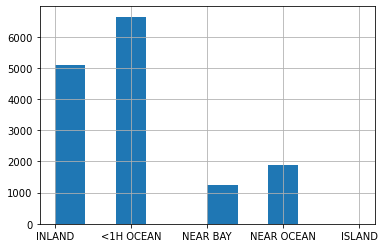

In [43]:
housing_clean['ocean_proximity'].hist()
housing_clean['ocean_proximity'].value_counts()

In [44]:
ohe=OneHotEncoder() #Instancio la clase
housing_cat_ohe=ohe.fit_transform(housing_clean[['ocean_proximity']])

In [45]:
housing_cat_ohe

<14889x5 sparse matrix of type '<class 'numpy.float64'>'
	with 14889 stored elements in Compressed Sparse Row format>

In [46]:
housing_cat_ohe.toarray()

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

Veamos a que se refiere ese encodeo

In [47]:
housing_clean[['ocean_proximity']]

,ocean_proximity
9106,INLAND
4477,<1H OCEAN
642,NEAR BAY
12955,INLAND
15706,NEAR BAY
...,...
929,NEAR BAY
8126,NEAR OCEAN
20039,INLAND
17420,NEAR OCEAN


### Estandarizacion

Cuando tenemos muchas features continuas, podemos tener problemas de unidades. Para evitar eso y que el algoritmo no asigne importancias espurias, conviene estandarizar. Estandarizar es fijar una estrategia para pasar los valores al intervalo [0,1], [-1,1] o lo que sea.
 
En particular, el `StandardScaler` transforma a x en "cantidad de desviaciones estandar de la media:

$x\rightarrow \frac{x-\mu}{\sigma}$

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [48]:
scaler = StandardScaler()

#fit_transform para train
train_num_scaled = scaler.fit_transform(housing_clean.drop("ocean_proximity", axis=1))

#transform para test
test_num_scaled = scaler.transform(housing_clean.drop("ocean_proximity", axis=1))

A continuacion se observan los valores estandarizados de ambos dataframes:

In [49]:
train_num_scaled

array([[ 0.74822754, -0.46199983,  0.96339871, ..., -1.17353087,
        -0.98867412, -0.96486835],
       [ 0.66762365, -0.71674871,  0.09027391, ...,  0.28390716,
        -0.64295317, -0.3497593 ],
       [-1.32732273,  0.97848931,  0.96339871, ..., -0.40375726,
        -0.39899351,  0.29969594],
       ...,
       [ 0.26964192,  0.20497907, -0.08435104, ..., -0.68344167,
        -1.09457465, -1.43842946],
       [-0.48098184, -0.45273623, -0.95747584, ..., -0.7963418 ,
        -1.83606936, -1.10641628],
       [ 0.778454  , -0.75380309, -0.17166352, ..., -0.31138443,
         1.62884552,  1.26451165]])

In [50]:
test_num_scaled

array([[ 0.74822754, -0.46199983,  0.96339871, ..., -1.17353087,
        -0.98867412, -0.96486835],
       [ 0.66762365, -0.71674871,  0.09027391, ...,  0.28390716,
        -0.64295317, -0.3497593 ],
       [-1.32732273,  0.97848931,  0.96339871, ..., -0.40375726,
        -0.39899351,  0.29969594],
       ...,
       [ 0.26964192,  0.20497907, -0.08435104, ..., -0.68344167,
        -1.09457465, -1.43842946],
       [-0.48098184, -0.45273623, -0.95747584, ..., -0.7963418 ,
        -1.83606936, -1.10641628],
       [ 0.778454  , -0.75380309, -0.17166352, ..., -0.31138443,
         1.62884552,  1.26451165]])

### Agregando features

La ingenieria de atributos tambien ayuda! En particular, podemos agregar los siguientes features (atributos)

In [51]:
#Genero 3 nuevos features artificiales

housing_clean["rooms_per_household"] = housing_clean["total_rooms"]/housing_clean["households"]
housing_clean["bedrooms_per_room"] = housing_clean["total_bedrooms"]/housing_clean["total_rooms"]
housing_clean["population_per_household"]=housing_clean["population"]/housing_clean["households"]

In [52]:
#Se observan los features generados

housing_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14889 entries, 9106 to 6335
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 14889 non-null  float64
 1   latitude                  14889 non-null  float64
 2   housing_median_age        14889 non-null  float64
 3   total_rooms               14889 non-null  float64
 4   total_bedrooms            14733 non-null  float64
 5   population                14889 non-null  float64
 6   households                14889 non-null  float64
 7   median_income             14889 non-null  float64
 8   median_house_value        14889 non-null  float64
 9   ocean_proximity           14889 non-null  object 
 10  rooms_per_household       14889 non-null  float64
 11  bedrooms_per_room         14733 non-null  float64
 12  population_per_household  14889 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.6+ MB


In [53]:
set(housing_clean["ocean_proximity"].values)

{'<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'}

# Definion del problema y target

El objetivo es poder predecir la mediana del precio de un distrito por sus caracteristicas. Es un problema de regresion univariada supervisada donde mi target es "median_house_value" y mis features son todas las otras categorias.

Dado que es un problema de regresion, voy a usar una de las metricas mas comunes. El root mean squared error. Si mi target es $\vec{t}=(t_1,t_2,...,t_N)^{T}$ y mis predicciones son $\vec{y}=(y_1,y_2,...,y_N)^{T}$, entonces

$\text{RMSE}(\vec{t},\vec{y})=\sqrt{\frac{1}{N}\sum_{n=1}^{N}(t_n-y_n)^{2}}$

La idea del RMSE es dar un error esperado a la prediccion


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

In [54]:
from sklearn.metrics import mean_squared_error

def rmse(y,t):
  return np.sqrt(mean_squared_error(y,t))

In [55]:
t_test_rmse=[0.1,0.3,-0.1]
y_test_rmse=[0.05,0.35,-0.05]
print(rmse(t_test_rmse,y_test_rmse))

0.05


Otra opción es utilizar "mean_squared_error(y_test_rmse,t_test_rmse,squared=False)" ya que devuelve el valor de RMSE directamente sin necesidad de definir la función que calcule la raíz cuadrada.

In [56]:
mean_squared_error(y_test_rmse,t_test_rmse,squared=False)

0.05

# Preprocesado de datos con pipeline


Voy a separar el target y escalar las variables numericas y re-expresar las categoricas. Combino todo en un pipeline.

Para ver mas sobre pipelines ver: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [57]:
housing_labels = housing_clean["median_house_value"].copy() #Labels de train

housing_clean = housing_clean.drop("median_house_value", axis=1) #Features de train. Aca elimino la columna con los labels
housing_cat = housing_clean[["ocean_proximity"]] #Feature categorico
housing_num = housing_clean.drop("ocean_proximity", axis=1) #Elimino el feature categorico para que me queden solo los numericos

https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

In [58]:
#Pipeline para los features numericos
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),#hay mas opciones aca ('mean','most_frequent' y 'constant')
                         ('std_scaler', StandardScaler())])

#Atributos numericos 
num_attribs = list(housing_num)

#Atributo categorico
cat_attribs = ["ocean_proximity"]

#Pipeline que integra los atributos numericos y el categorico
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs)])

#Ejecuto el pipeline en el dataset de entranemiento
housing_prepared = full_pipeline.fit_transform(housing_clean)

In [81]:
#Atributos numericos que se pasaron por full_pipeline

num_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household']

In [84]:
#Atributo categorico que se paso por full_pipeline

cat_attribs

['ocean_proximity']

Aca pasaron muchas cosas... Vamos paso por paso

El `num_pipeline` tiene dos pasos. Primero, el `SimpleImputer` se ocupa de rellenar los datos faltantes. Utiliza la mediana del feature faltante. Segundo, el `StandardScaler()` se ocupa de estandarizar los datos

In [59]:
#Realizo como ejemplo la transformacion de los features numericos

housing_num_transformed=num_pipeline.fit_transform(housing_num)

Veamos el imputer

In [60]:
#Como vimos anteriormente la columna 'total_bedrooms' tiene valores faltantes

housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14889 entries, 9106 to 6335
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 14889 non-null  float64
 1   latitude                  14889 non-null  float64
 2   housing_median_age        14889 non-null  float64
 3   total_rooms               14889 non-null  float64
 4   total_bedrooms            14733 non-null  float64
 5   population                14889 non-null  float64
 6   households                14889 non-null  float64
 7   median_income             14889 non-null  float64
 8   rooms_per_household       14889 non-null  float64
 9   bedrooms_per_room         14733 non-null  float64
 10  population_per_household  14889 non-null  float64
dtypes: float64(11)
memory usage: 1.4 MB


In [61]:
#Cantidad de valores faltantes de 'total_bedrooms'

len(housing_num_transformed[np.where(housing_num['total_bedrooms'].isnull())])

156

In [62]:
housing_num['total_bedrooms'].isnull().sum()

156

In [63]:
#Veo como fueron imputados los valores faltantes en 'total_bedrooms'

housing_num_transformed[np.where(housing_num['total_bedrooms'].isnull()),4]

array([[-0.24462674, -0.24462674, -0.24462674, -0.24462674, -0.24462674,
        -0.24462674, -0.24462674, -0.24462674, -0.24462674, -0.24462674,
        -0.24462674, -0.24462674, -0.24462674, -0.24462674, -0.24462674,
        -0.24462674, -0.24462674, -0.24462674, -0.24462674, -0.24462674,
        -0.24462674, -0.24462674, -0.24462674, -0.24462674, -0.24462674,
        -0.24462674, -0.24462674, -0.24462674, -0.24462674, -0.24462674,
        -0.24462674, -0.24462674, -0.24462674, -0.24462674, -0.24462674,
        -0.24462674, -0.24462674, -0.24462674, -0.24462674, -0.24462674,
        -0.24462674, -0.24462674, -0.24462674, -0.24462674, -0.24462674,
        -0.24462674, -0.24462674, -0.24462674, -0.24462674, -0.24462674,
        -0.24462674, -0.24462674, -0.24462674, -0.24462674, -0.24462674,
        -0.24462674, -0.24462674, -0.24462674, -0.24462674, -0.24462674,
        -0.24462674, -0.24462674, -0.24462674, -0.24462674, -0.24462674,
        -0.24462674, -0.24462674, -0.24462674, -0.2

Y el StandardScaler

In [64]:
#Observo las medias de cada columna

num_pipeline.named_steps['std_scaler'].mean_

array([-1.19505243e+02,  3.56174525e+01,  2.69660823e+01,  2.67886030e+03,
        5.48546377e+02,  1.47279683e+03,  5.10354288e+02,  3.69385611e+00,
        5.39594352e+00,  2.13888252e-01,  3.09392176e+00])

In [65]:
housing_prepared.shape

(14889, 16)

# Regresion


Jueguen ustedes un poco con las distintas opciones de modelo que damos a continuacion. Elijan cual les parece el mejor argumentandolo. El pseudo codigo de lo **minimo** que hay que hacer es el siguiente:

In [66]:
from sklearn.linear_model import LinearRegression #Regresion lineal
from sklearn.tree import DecisionTreeRegressor #Regresion por arbol de decision
from sklearn.ensemble import RandomForestRegressor #Regresion con RandomForest

''' pseudo codigo '''

'''
modelo = algoritmo()

modelo.fit(algo...)

y_pred_train = modelo.predict(algo...)

print(metrica(algo...)) '''

'\nmodelo = algoritmo()\n\nmodelo.fit(algo...)\n\ny_pred_train = modelo.predict(algo...)\n\nprint(metrica(algo...)) '

Las predicciones se realizaran para los datos utilizados en entrenamiento. No es el enfoque correcto, pero a modo de ejemplo sirve

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [67]:
#Regresion lineal

modelo_1 = LinearRegression() #Instancio la clase
modelo_1.fit(housing_prepared,housing_labels) #Realizo el fit()
y_pred_modelo_1 = modelo_1.predict(housing_prepared) #Predigo para nuevos valores: En este caso la prediccion es para los features de entrenamiento
print(rmse(y_pred_modelo_1,housing_labels)) #Calculo la metrica RMSE

58338.87236505782


https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [68]:
#Regresion por arbol de decision

modelo_2 = DecisionTreeRegressor() #Instancio la clase
modelo_2.fit(housing_prepared,housing_labels) #Realizo el fit()
y_pred_modelo_2 = modelo_2.predict(housing_prepared) #Predigo para nuevos valores: En este caso la prediccion es para los features de entrenamiento
print(rmse(y_pred_modelo_2,housing_labels)) #Calculo la metrica RMSE

0.0


https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [69]:
#Regresion con RandomForest

modelo_3 = RandomForestRegressor() #Instancio la clase
modelo_3.fit(housing_prepared,housing_labels) #Realizo el fit()
y_pred_modelo_3 = modelo_3.predict(housing_prepared) #Predigo para nuevos valores: En este caso la prediccion es para los features de entrenamiento
print(rmse(y_pred_modelo_3,housing_labels)) #Calculo la metrica RMSE

16665.087729379902


Recuerden que se puede ver la documentacion con 

In [70]:
LinearRegression?

Y, si pueden, vayan mas alla del pseudo-codigo porque hay un trampa...

# Mis soluciones (no lo vean antes de terminar con lo otro...)

Vamos a resolver el problema. Voy a probar varios algoritmos (sin justificarlos bien, ya los vamos a ver) y evaluar la performance.

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import tree

## Underfitting con Regresion Lineal

Defino otro Pipeline solo para mostrar, no es estrictamente necesario.

$y = w_0 + \sum_{i=1}^{M}w_{i}\phi_{i}(\vec{x})$

$\phi_{i} = x_{i} $

$y = w_0 + \sum_{i=1}^{16}w_{i}x_{i}$

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [76]:
full_pipeline_with_predictor_lr = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())])

scores_lr=cross_val_score(full_pipeline_with_predictor_lr, housing, housing_labels,scoring="neg_mean_squared_error", cv=10)#no lo aplico en housing_prepared, no deberia cambiar pero igual
cross_scores_lr = np.sqrt(-scores_lr)

print("Puntajes:", cross_scores_lr)
print("Media:", cross_scores_lr.mean())
print("Desviacion Estandar:", cross_scores_lr.std())

full_pipeline_with_predictor_lr.fit(housing, housing_labels)
predictions_lr=full_pipeline_with_predictor_lr.predict(housing)
print("Ejemplo: ", (round(predictions_lr[100]),housing_labels[100]))
print("MSE Total del conjunto de entrenamiento:", np.sqrt(mean_squared_error(predictions_lr,housing_labels)))

ValueError: Found input variables with inconsistent numbers of samples: [16512, 14889]

In [72]:
len(housing)

16512

In [73]:
len(housing["median_house_value"])

16512

In [74]:
len(housing_labels)

14889

In [75]:
len(housing_prepared)

14889

Por lo visto el error anterior se genera por que "housing" tiene 16512 registros y "housing_labels" tiene 14889 registros

In [95]:
#Sacando toda la sección de 'cross_val_score' se puede entrenar y predecir con el modelo

#Pipeline que realiza todo el preprocesamiento y al final instancia el modelo, en este caso un modelo lineal de regresion
full_pipeline_with_predictor_lr = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())])

#Realizo el entrenamiento
full_pipeline_with_predictor_lr.fit(housing_clean, housing_labels)

#Realizo las predicciones para el set de entrenamiento
predictions_lr=full_pipeline_with_predictor_lr.predict(housing_clean)

#Imprimo una prediccion y un valor verdadero del label
print("Ejemplo: ", (round(predictions_lr[100]),housing_labels[100]))

#Imprimo el valor de RMSE para todas las predicciones
print("RMSE Total del conjunto de entrenamiento:", np.sqrt(mean_squared_error(predictions_lr,housing_labels)))

Ejemplo:  (294509.0, 257800.0)
RMSE Total del conjunto de entrenamiento: 58338.87236505782


Text(0, 0.5, 'y')

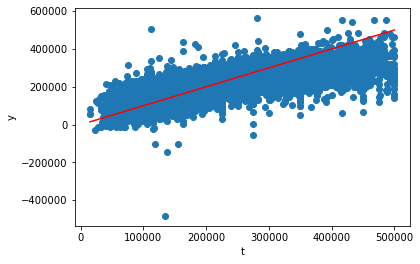

In [88]:
#Realizo un scatterplor entre los labels verdaderos y las que predice el modelo lineal
#A su vez grafico una linea entre el punto maximo y minimo de housing_labels

x=np.linspace(min(housing_labels),max(housing_labels),3)
plt.scatter(housing_labels,predictions_lr)
plt.plot(x,x,color='red')
plt.xlabel('t')
plt.ylabel('y')

## Overfitting con Decision Tree

In [98]:
#Instancio el modelo
tree_reg = DecisionTreeRegressor(random_state=42,max_depth=7)

#Realizo el entrenamiento
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(max_depth=7, random_state=42)

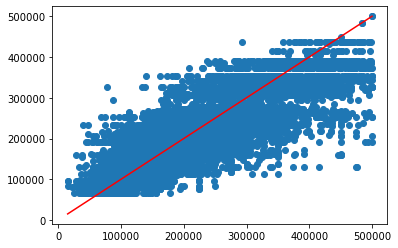

In [99]:
#Realizo un scatterplor entre los labels verdaderos y las que predice el modelo de arbol
#A su vez grafico una linea entre el punto maximo y minimo de housing_labels

x=np.linspace(min(housing_labels),max(housing_labels),3)
plt.scatter(housing_labels,tree_reg.predict(housing_prepared))
plt.plot(x,x,color='red')

In [102]:
#Calculo el RMSE de las predicciones

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

50749.26340192814

In [103]:
#Return the number of leaves of the decision tree.

tree_reg.get_n_leaves()

124

In [93]:
#Calculo los scores de validacion cruzada, la media y el desvio estandar de ellos

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

print("Puntajes:", tree_rmse_scores)
print("Media:", tree_rmse_scores.mean())
print("Desviacion Estandar:", tree_rmse_scores.std())

Puntajes: [56456.75067788 58042.37106613 57966.86794057 54275.45364325
 54144.04451893 57681.87254923 53003.10889563 55146.23049692
 54077.7458279  56061.16618905]
Media: 55685.5611805494
Desviacion Estandar: 1729.628854818691


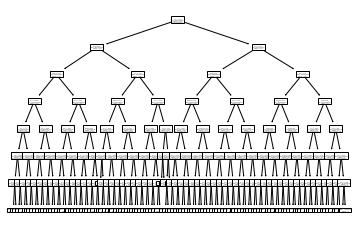

In [94]:
#Grafico el arbol

tree.plot_tree(tree_reg) 
plt.show()

## Fitting con RandomForest

In [104]:
#Se define una grilla de hyperparametros: Se observa 2 conjuntos separados por {3x4} = 12 combinaciones, {1x2x3} = 6 combinaciones

param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]

#Instancio la clase del modelo
forest_reg = RandomForestRegressor(random_state=42)

#Realizo la busque exhaustiva de hyperparametros por medio de GridSearchCV que incluye validacion cruzada. Utiliza 5 folds
# (12+6)*5=90 entranamientos
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
#Entreno mediante GridSearchCV
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [105]:
#Imprimo los mejores parametros obtenidos con GridSearchCV
print("Best params:", grid_search.best_params_)

#Imprimo el mejor estimador de todas las combinaciones realizadas
print("Best estimator:", grid_search.best_estimator_)


Best params: {'max_features': 8, 'n_estimators': 30}
Best estimator: RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)


In [107]:
grid_search.cv_results_

{'mean_fit_time': array([0.44708915, 0.48041844, 2.25153456, 0.42184992, 0.80780535,
        2.75486388, 0.59189353, 1.96237154, 5.95320158, 0.39555683,
        1.41006794, 4.54752555, 0.30602255, 1.4708477 , 0.35319762,
        1.14397106, 0.47395797, 1.32468324]),
 'std_fit_time': array([0.56607994, 0.04509251, 1.5677902 , 0.07898438, 0.19537362,
        1.55246112, 0.09468896, 0.47621198, 0.95878708, 0.04052493,
        0.09153507, 1.0238194 , 0.08231116, 0.38238275, 0.09035178,
        0.16449038, 0.075421  , 0.07212009]),
 'mean_score_time': array([0.05527387, 0.03018122, 0.10333757, 0.01848936, 0.03578053,
        0.07155933, 0.02238822, 0.04537334, 0.10715108, 0.00999565,
        0.03389015, 0.14317398, 0.01358972, 0.03697472, 0.01159391,
        0.03937526, 0.01929197, 0.03885298]),
 'std_score_time': array([0.04737468, 0.01146893, 0.04452357, 0.00303311, 0.00986236,
        0.02087898, 0.00895267, 0.0215794 , 0.0216787 , 0.00282856,
        0.00544705, 0.11916964, 0.0085171 , 

In [108]:
#Para cada set de hyperparametros imprimo una serie de metricas y los parametros

cvres = grid_search.cv_results_
for mean_score, std, params in zip(cvres["mean_test_score"], cvres["std_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), np.sqrt(std),params)

57759.43356653236 10059.82080467909 {'max_features': 2, 'n_estimators': 3}
49867.05941961984 8193.859552546486 {'max_features': 2, 'n_estimators': 10}
47711.40133967307 7752.843985571028 {'max_features': 2, 'n_estimators': 30}
55299.18392165632 11644.011893726085 {'max_features': 4, 'n_estimators': 3}
47817.580066033894 8031.9997863602375 {'max_features': 4, 'n_estimators': 10}
45784.0611524469 8978.177244454428 {'max_features': 4, 'n_estimators': 30}
52813.488809810726 8730.75614887072 {'max_features': 6, 'n_estimators': 3}
47035.80665338223 7096.222805440639 {'max_features': 6, 'n_estimators': 10}
45075.90717782322 8123.797535381053 {'max_features': 6, 'n_estimators': 30}
53199.37486009662 10886.551747701862 {'max_features': 8, 'n_estimators': 3}
47043.962434320296 8522.53684046737 {'max_features': 8, 'n_estimators': 10}
45040.58924202858 8811.094765717171 {'max_features': 8, 'n_estimators': 30}
55997.56728115439 8930.179896058848 {'bootstrap': False, 'max_features': 2, 'n_estimators

In [112]:
#Utilizo los mejores parametros de GridSearchCV para luego predecir

best_rf=grid_search.best_estimator_

#Imprimo un ejemplo de prediccion y de valor verdadero
print("Example: ", round(best_rf.predict(housing_prepared)[100]),housing_labels[100])
                                                                                
#Imprimo el RMSE para los datos de train                                                                               
print("Train MSE: ",np.sqrt(mean_squared_error(best_rf.predict(housing_prepared),housing_labels)))

Example:  319860.0 257800.0
Train MSE:  17407.664977267606


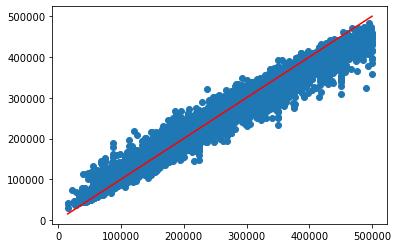

In [110]:
#Realizo un scatterplor entre los labels verdaderos y las que predice el modelo de RandomForest
#A su vez grafico una linea entre el punto maximo y minimo de housing_labels

x=np.linspace(min(housing_labels),max(housing_labels),3)
plt.scatter(housing_labels,best_rf.predict(housing_prepared))
plt.plot(x,x,color='red')

## Una Red Neuronal

In [114]:
#Importo las librerias

import tensorflow as tf #Tensorflow
from tensorflow import keras #Keras
tf.random.set_seed(42) #Fijo la semilla
keras.backend.clear_session() #Limpio la sesion

In [116]:
#Realizo el spliting del dataset que tiene los features numericos (no utilizo el feature categorico)

X_train, X_valid, y_train, y_valid = train_test_split(housing_num, housing_labels, random_state=42)

#Fiteo y tranformo el dataset de train
X_train_proc=num_pipeline.fit_transform(X_train)

#Transformo el dataset de test
X_valid_proc=num_pipeline.transform(X_valid)

In [124]:
#Estandarizo los valores de los labels

scaler = StandardScaler()
y_train_proc = scaler.fit_transform(np.asarray(y_train).reshape(-1,1))
y_valid_proc = scaler.transform(np.asarray(y_valid).reshape(-1,1))


In [125]:
y_train_proc[:,0].shape

(11166,)

In [119]:
input_shape = X_train_proc.shape[1:]
batch_size = 128
epochs = 50

In [126]:
#Defino el modelo de la red neuronal que voy a utilizar

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [127]:
#Compilo el modelo

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

In [128]:
#Imprimo un resumen del modelo creado

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 30)                360       
_________________________________________________________________
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________


In [129]:
#Ploteo el modelo (no funciona)

tf.keras.utils.plot_model(model)

InvocationException: Program terminated with status: 1. stderr follows: Format: "ps" not recognized. Use one of:


In [130]:
#Early Sttoping = Stop training when a monitored metric has stopped improving.

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

#Entreno el modelo
history = model.fit(X_train_proc, y_train_proc[:,0], epochs=epochs,
                    validation_data=(X_valid_proc, y_valid_proc[:,0]),
                    callbacks=[early_stopping_cb])

Epoch 1/50
349/349 [==============================] - 11s 33ms/step - loss: 0.8845 - val_loss: 0.7179
Epoch 2/50
349/349 [==============================] - 8s 23ms/step - loss: 0.6474 - val_loss: 0.5774
Epoch 3/50
349/349 [==============================] - 10s 29ms/step - loss: 0.5523 - val_loss: 0.5082
Epoch 4/50
349/349 [==============================] - 8s 22ms/step - loss: 0.5071 - val_loss: 0.4755
Epoch 5/50
349/349 [==============================] - 10s 29ms/step - loss: 0.4816 - val_loss: 0.4541
Epoch 6/50
349/349 [==============================] - 7s 20ms/step - loss: 0.4629 - val_loss: 0.4391
Epoch 7/50
349/349 [==============================] - 7s 20ms/step - loss: 0.4471 - val_loss: 0.4253
Epoch 8/50
349/349 [==============================] - 8s 24ms/step - loss: 0.4328 - val_loss: 0.4114
Epoch 9/50
349/349 [==============================] - 7s 21ms/step - loss: 0.4197 - val_loss: 0.3987
Epoch 10/50
349/349 [==============================] - 7s 21ms/step - loss: 0.4076 - val

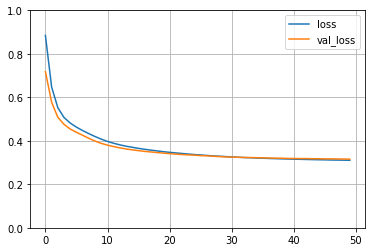

In [131]:
#Imprimo como varia la funcion de perdida para entrenamiento y validacion a lo largo de las epocas

pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [132]:
#Evaluo el modelo para los datos de entrenamiento

mse_train = model.evaluate(X_train_proc, y_train_proc)

349/349 [==============================] - 0s 1ms/step - loss: 0.3097


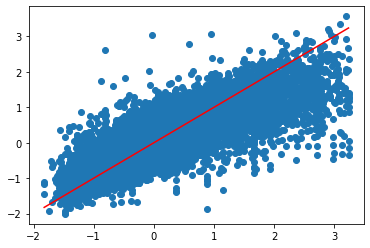

In [133]:
#Realizo un scatterplor entre los labels verdaderos y las que predice el modelo de Red Neuronal
#A su vez grafico una linea entre el punto maximo y minimo de housing_labels

x=np.linspace(min(y_train_proc[:,0]),max(y_train_proc[:,0]),3)
plt.scatter(y_train_proc[:,0],model.predict(X_train_proc))
plt.plot(x,x,color='red')

In [135]:
#Imprimo el RMSE

np.sqrt(mean_squared_error(scaler.inverse_transform(model.predict(X_train_proc)),scaler.inverse_transform(y_train_proc)))

53332.178452197884

# Vamos al Test

En clase podemos hacerlo incompleto...

In [136]:
housing_test_clean["rooms_per_household"] = housing_test_clean["total_rooms"]/housing_test_clean["households"]
housing_test_clean["bedrooms_per_room"] = housing_test_clean["total_bedrooms"]/housing_test_clean["total_rooms"]
housing_test_clean["population_per_household"]=housing_test_clean["population"]/housing_test_clean["households"]

In [137]:
housing_test_labels = housing_test_clean["median_house_value"].copy()
housing_test_clean = housing_test_clean.drop("median_house_value", axis=1) # drop labels for training set
housing_test_cat = housing_test_clean[["ocean_proximity"]]
housing_test_num = housing_test_clean.drop("ocean_proximity", axis=1)

In [138]:
housing_test_prepared = full_pipeline.transform(housing_test_clean)

Evaluo el mejor algoritmo: RandomForest

In [139]:
print("Test MSE: ",np.sqrt(mean_squared_error(best_rf.predict(housing_test_prepared),housing_test_labels)))

Test MSE:  43689.874752403106


# Algunos ejericicios (que pueden ser para dentro de unas clases...)





*   Esta bueno poder mostrar un grafico lindo. En particular, el mapa de latitud y longitud es bastante claro. Jueguen con los tres algoritmos que utilizamos pero ahora utilizando como features latitud y longitud. Para cada algoritmo dibuje el mapa y las regiones inferidas de precio utilizando plt.contourf. Por que sugerimos utilizar unicamente dos variables a la hora de entrenar en lugar de utilizar los algoritmos ya entrenados?
*   Reemplacen el GridSearchCV por el RandomizedSearchCV. No se preocupen, lo vamos a ver en detalle mas adelante.
*   Fijense si puede juntar el preprocesado de los datos y los distintos algoritmos en un solo Pipeline. Que hiperparametros tiene? Pueden implementarlos en GridSearchCV?


